# Quijote $C_{\ell}$ of the LOS pecululiar velocity covariance

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import healpy
from h5py import File

import csiborgtools
import healpy as hp
from scipy.special import spherical_jn
from scipy.interpolate import interp1d
from scipy.integrate import quad

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
k, Pk = np.load("/mnt/users/rstiskalek/BayesianBulkFlows/data/pk_fiducial.npy").T
loglog_Pk = interp1d(np.log(k), np.log(Pk))

def Pk(k):
    return np.exp(loglog_Pk(np.log(k)))


def djn(n, x):
    return (n / x) * spherical_jn(n, x) - spherical_jn(n + 1, x)


def C_ell_theory_equal_radius(ell, r):
    dDdtau = 35.5
    
    norm = dDdtau**2 
    integrand = lambda k: norm * Pk(k) * djn(ell, k * r)**2
    return quad(integrand, 0.0001, 10, limit=1000, limlst=5)[0]


In [12]:
num_simulations = None
load_skymaps = False

with File("/mnt/extraspace/rstiskalek/BBF/Quijote_Cell/C_ell_fiducial.h5", 'r') as f:
    num_observers = f.attrs["num_observers"]
    num_radii = f.attrs["num_radii"]
    npix_per_map = f.attrs["npix_per_map"]
    if num_simulations is None:
        num_simulations = f.attrs["num_simulations"]

    ell = f["ell"][:]
    radii = f["radii"][:]

    Cell = []
    if load_skymaps:
        skymap = []

    for n in range(num_simulations):
        grp_simulation = f[f"nsim_{n}"]

        for i in range(num_observers):
            grp_observer = grp_simulation[f"observer_{i}"]

            Cell_ = np.full((num_radii, len(ell)), np.nan)
            if load_skymaps:
                skymap_ = np.full((num_radii, npix_per_map), np.nan)
            else:
                skymap_ = None

            for j in range(num_radii):
                Cell_[j] = grp_observer[f"C_ell_{j}"][...]
                if load_skymaps:
                    skymap_[j] = grp_observer[f"skymap_{j}"][...]


            Cell.append(Cell_)
            if load_skymaps:
                skymap.append(skymap_)


Cell = np.stack(Cell)
if load_skymaps:
    skymap = np.stack(skymap)


print(f"Num. simulations:   {num_simulations}")
print(f"Num. observers:     {num_observers}")
print(f"Num. radii:         {num_radii}")
print(f"Radii:              {radii}")



print("Dividing the dipole by a factor of 9:")
Cell[..., 1] /= 9

Num. simulations:   50
Num. observers:     8
Num. radii:         5
Radii:              [100.  112.5 125.  137.5 150. ]
Dividing the dipole by a factor of 9:


In [10]:
# healpy.mollview(skymap[2, 4], title=None, cmap="coolwarm", unit=r"$V_{\rm rad} ~ [{\rm km/s}]$", )
# plt.savefig("../../plots/skymap.png", dpi=450)

In [21]:
k = -1


ytheory = [C_ell_theory_equal_radius(i, radii[k]) for i in ell]

/tmp/ipykernel_1113107/3790696556.py:17: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return quad(integrand, 0.0001, 10, limit=1000, limlst=5)[0]


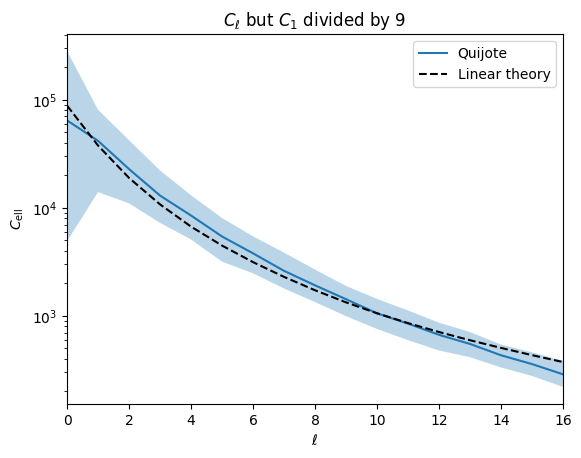

In [23]:
plt.figure()

plt.title(r"$C_{\ell}$ but $C_{1}$ divided by 9")
ylow, ymed, yhigh = np.percentile(Cell[:, k, :], [16, 50, 84], axis=0)
plt.plot(ell, ymed, label="Quijote")
plt.fill_between(ell, ylow, yhigh, alpha=0.3)
plt.plot(ell, ytheory, label="Linear theory", color="black", linestyle="--")

plt.legend()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_{\rm ell}$")
plt.xlim(ell.min(), ell.max())
plt.yscale("log")

plt.savefig("../../plots/C_ell.png", dpi=450)

plt.show()

In [ ]:


fig, axs = plt.subplots(len(radii), 1, figsize=(5, 4 * len(radii)), sharex=True)

for k in range(len(radii)):

    ylow, ymed, yhigh = np.percentile(C_ell[:, k], [16, 50, 84], axis=0)
    axs[k].plot(ell, ymed, label=rf"$R = {radii[k]} ~ [\mathrm{{Mpc}} / h]$")
    axs[k].fill_between(ell, ylow, yhigh, alpha=0.1)

    Cell_theory = [C_ell_theory_equal_radius(ell_, radii[k]) for ell_ in ell]
    axs[k].plot(ell, Cell_theory, color="black", label="Theory")

    axs[k].set_yscale("log")
    axs[k].legend()

    axs[k].set_ylabel(r"$C_{\ell}$")
    axs[k].set_xlabel(r"$\ell$")

axs[-1].set_xlim(0, ell.max())

fig.tight_layout()
fig.savefig("../../plots/C_ell_fiducial.png", dpi=450)
fig.show()

In [ ]:
hp.mollview(skymap[4], unit=r"$V_{\rm rad} ~ [\mathrm{km} / \mathrm{s}]$",  cmap="coolwarm")

In [ ]:
k = 4

Cell_theory = [C_ell_theory_equal_radius(ell_, radii[k]) for ell_ in ell]

plt.figure()
plt.title(f"R = {radii[k]}")


for n in range(50):
    plt.plot(ell, C_ell[n, k], alpha=0.1, color="black")


plt.plot(ell, C_ell[0, k], color="red", label="Simulated")
plt.plot(ell, Cell_theory, color="blue", label="Theory")

plt.yscale("log")
plt.show()
